In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
from rdkit.Chem.Draw import IPythonConsole

from molclub.compute import gfnxtb, orca_dft
from molclub.conf_tools import etkdg, crest, conf_utils
from molclub import visualize

orca_dir = '/Users/ozone/bin/_orca_5_0_3'

## loading clinical molecules

In [315]:
df = pd.read_csv('data/clinical_molecules.csv', delimiter=';')
df = df.rename(columns={'Smiles': 'smi'})
df = (
    df.loc[df.Type == 'Small molecule']
    [['smi']]
    .dropna()
)

In [316]:
salts = """
[Na]
[K]
[Mg]
[Ca]
[Sr]
[Ag]
[Zn]
[Al]
[Bi]
[Cl]
[Br]
[I]
O
N
[K]S[K]
CC(=O)O
C[C@H](O)C(=O)O
CCO
NCCN
NCCO
OCC(O)CO
OCCNCCO
NC(CO)(CO)CO
CC(O)CN(C)C
OCCN1CCCC1
CNC(C)CC1CCCCC1
C1N2CN3CN1CN(C2)C3
C[N+](C)(C)CCO
O=[N+]([O-])O
O=S(=O)(O)O
O=P(O)(O)O
O=C(O)c1ccccc1
C[S+](C)[O-]
CS(=O)(=O)O
COS(=O)(=O)[O-]
O=S(=O)(O)c1ccccc1
Cc1ccc(S(=O)(=O)O)cc1
O=S(=O)(O)c1ccc2ccccc2c1
CCCCCCCCCCCCOS(=O)(=O)O
O=C(O)CCC(=O)O
N[C@@H](CC(=O)O)C(=O)O
O=C(O)/C=C\C(=O)O
O=C(O)C[C@H](O)C(=O)O
O=C(O)C(O)C(O)C(=O)O
O=S(=O)(O)CCS(=O)(=O)O
O=S(=O)([O-])c1ccccc1
O=C(O)CC(O)(CC(=O)O)C(=O)O
CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O=C(O)[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
O=C([O-])c1cc2ccccc2c(Cc2c(O)c(C(=O)[O-])cc3ccccc23)c1O
"""
salts = salts.strip('\n')
remover = SaltRemover(defnData=salts)
def deduplicate(smi):
    return '.'.join(set(smi.split('.')))
df.smi = df.smi.apply(lambda x: deduplicate(x))
df.smi = df.smi.apply(lambda x: Chem.MolToSmiles(remover.StripMol(Chem.MolFromSmiles(x), dontRemoveEverything=True)))
df = (
    df.loc[(df.smi.str.contains('c')) | (df.smi.str.contains('C'))]
    .loc[df.smi.apply(lambda x: '.' not in x)]
)
df['mol'] = df.smi.apply(lambda x: Chem.MolFromSmiles(x))
df['n_rot_bonds'] = df.mol.apply(lambda x: CalcNumRotatableBonds(x))
df['mol_wt'] = df.mol.apply(lambda x: MolWt(x))
df = (
    df.loc[(df.n_rot_bonds <= 10) & (df.mol_wt <= 500)]
)

print(df.shape)
df.head()

[10:59:38] WARNING: not removing hydrogen atom without neighbors


(4865, 4)


,smi,mol,n_rot_bonds,mol_wt
0,CN(C)C(=O)COC(=O)Cc1ccc(OC(=O)c2ccc(NC(=N)N)cc...,<rdkit.Chem.rdchem.Mol object at 0x29bffb820>,7,398.419
1,CN(C)CCOc1ccc(/C(=C(/CCCl)c2ccccc2)c2ccccc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x29bffb880>,9,405.969
2,O=C1NC(c2cccc([N+](=O)[O-])c2)=CCN1c1ccccc1O,<rdkit.Chem.rdchem.Mol object at 0x29bffbdc0>,3,311.297
4,C[C@]12COC(=O)C[C@@H]1CC[C@@H]1[C@@H]2CC[C@@]2...,<rdkit.Chem.rdchem.Mol object at 0x29bffbca0>,0,306.446
5,C[C@]1(c2nc3cccc(C(N)=O)c3[nH]2)CCCN1,<rdkit.Chem.rdchem.Mol object at 0x29bffbd00>,2,244.298


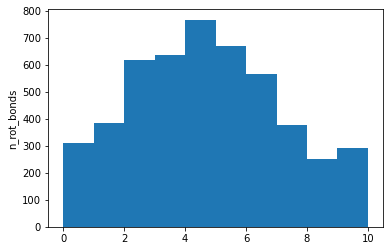

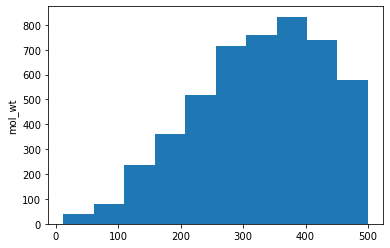

In [317]:
plt.hist(df['n_rot_bonds'])
plt.ylabel('n_rot_bonds')
plt.show()
plt.hist(df['mol_wt'])
plt.ylabel('mol_wt')
plt.show()

In [320]:
list_dfs = []
n_rot_bonds_bins = [0, 2, 4, 6, 8, 10]
mol_wt_bins = [0, 100, 200, 300, 400, 500]
for n_rot_bonds_left, n_rot_bonds_right in zip(n_rot_bonds_bins[:-1], n_rot_bonds_bins[1:]):
    for mol_wt_left, mol_wt_right in zip(mol_wt_bins[:-1], mol_wt_bins[1:]):
        subset = (
            df.loc[(df.n_rot_bonds > n_rot_bonds_left) & (df.n_rot_bonds <= n_rot_bonds_right)]
            .loc[(df.mol_wt > mol_wt_left) & (df.mol_wt <= mol_wt_right)]
        )
        subset = subset.sample(min(5, len(subset)))
        subset['bin'] = [(n_rot_bonds_left, mol_wt_left)] * len(subset)
        list_dfs.append(subset)
df_subset = pd.concat(list_dfs)

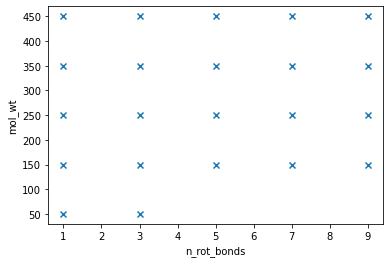

In [321]:
unique_bins = set(df_subset.bin)
plt.scatter([tup[0]+1 for tup in unique_bins], [tup[1]+50 for tup in unique_bins], marker='x')
plt.xlabel('n_rot_bonds')
plt.ylabel('mol_wt')
plt.show()

In [323]:
# df_subset.to_pickle('data/clinical_molecules_subset.pkl')

## utils

In [12]:
def xtb_vs_dft(mol, show_stats=False):
    print('creating initial conformer')
    mols = etkdg.generate_conformers(mol, 1)

    print('finding conformers with crest')
    params = crest.Parameters(search_intensity='fast')
    mols = crest.generate_conformers(mols[0], crest_params=params)
    
    df = pd.DataFrame({'mol': mols})

    print('getting xtb energies')
    xtb_energies = [gfnxtb.sp(m) for m in df.mol]
    min_energy = min(xtb_energies)
    xtb_energies = [energy - min_energy for energy in xtb_energies]
    df['e_xtb'] = xtb_energies

    df = df.nsmallest(20, columns=['e_xtb'])

    print('getting dft energies')
    dft_energies = [orca_dft.sp(m, orca_dir) for m in df.mol]
    min_energy = min(dft_energies)
    dft_energies = [energy - min_energy for energy in dft_energies]
    df['e_dft'] = dft_energies

    df = df.sort_values(['e_dft'])

    print('collecting stats')
    boltz = conf_utils.boltzmann_pop(df.e_dft)
    boltz += [0] * (len(df) - len(boltz))
    df['boltz'] = boltz

    pearson_r = pearsonr(df.e_xtb, df.e_dft)
    mae = mean_absolute_error(df.e_dft, df.e_xtb)
    rmse = mean_squared_error(df.e_dft, df.e_xtb, squared=False)
    dft_top_5 = sum(df.boltz[:5])
    xtb_top_5 = sum(df.sort_values(['e_xtb']).boltz[:5])
    stat_dict = {
        'pearson_r': pearson_r,
        'mae': mae,
        'rmse': rmse,
        'dft_top_5': dft_top_5,
        'xtb_top_5': xtb_top_5,
    }

    if show_stats:
        display(Chem.Mol(mol, quickCopy=True))
        for key, value in zip(stat_dict.keys(), stat_dict.values()):
            print(f'{key}: {value}')
        plt.scatter(range(len(df)), df.e_xtb, color='blue', label='gfn2-xtb')
        plt.scatter(range(len(df)), df.e_dft, color='red', label='r2scan-3c')
        plt.legend()
        plt.show()

    return stat_dict

## comparisons!

In [2]:
df_subset = pd.read_pickle('data/clinical_molecules_subset.pkl')

df_subset.head()

,smi,mol,n_rot_bonds,mol_wt,bin
8885,CC(O)CO,<rdkit.Chem.rdchem.Mol object at 0x13e65b4c0>,1,76.095,"(0, 0)"
9519,NCCS,<rdkit.Chem.rdchem.Mol object at 0x13e65b560>,1,77.152,"(0, 0)"
95,OCC(O)CO,<rdkit.Chem.rdchem.Mol object at 0x13e65b600>,2,92.094,"(0, 0)"
707,NCCN,<rdkit.Chem.rdchem.Mol object at 0x13e65b6a0>,1,60.100,"(0, 0)"
492,CCC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x13e65b740>,1,74.079,"(0, 0)"


,smi,mol,n_rot_bonds,mol_wt,bin
8885,CC(O)CO,<rdkit.Chem.rdchem.Mol object at 0x13e65b4c0>,1,76.095,"(0, 0)"
9519,NCCS,<rdkit.Chem.rdchem.Mol object at 0x13e65b560>,1,77.152,"(0, 0)"
95,OCC(O)CO,<rdkit.Chem.rdchem.Mol object at 0x13e65b600>,2,92.094,"(0, 0)"
707,NCCN,<rdkit.Chem.rdchem.Mol object at 0x13e65b6a0>,1,60.100,"(0, 0)"
492,CCC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x13e65b740>,1,74.079,"(0, 0)"


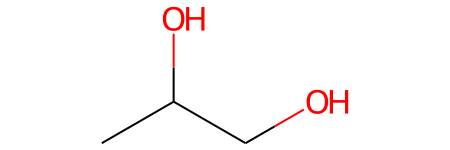

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats
pearson_r: (0.9784996727884809, 0.13225096929960234)
mae: 0.3284957808373292
rmse: 0.40752059161467563
dft_top_5: 0.9999999999999999
xtb_top_5: 0.9999999999999999


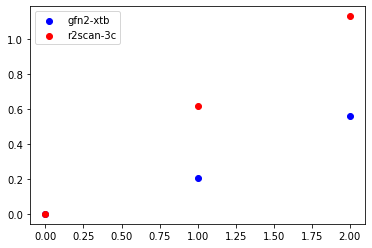

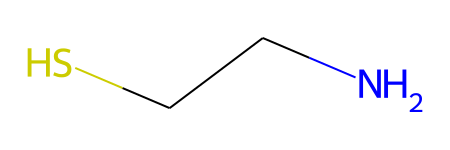

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats
pearson_r: (0.985961783586766, 0.10679734595235067)
mae: 0.11577605062363243
rmse: 0.14412860578077677
dft_top_5: 0.9999999999999999
xtb_top_5: 0.9999999999999999


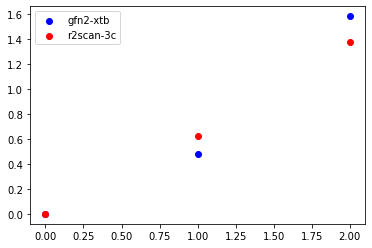

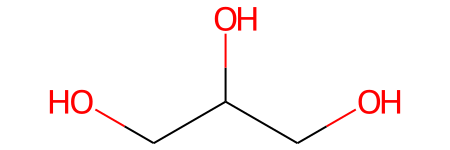

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats
pearson_r: (0.7951396686341805, 0.010418828075980116)
mae: 0.37671429529493455
rmse: 0.47908316191044426
dft_top_5: 1.0
xtb_top_5: 0.6847223199175609


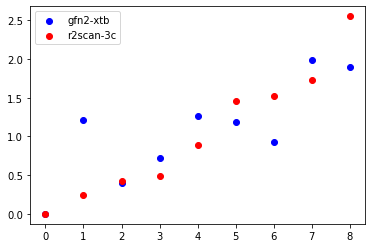

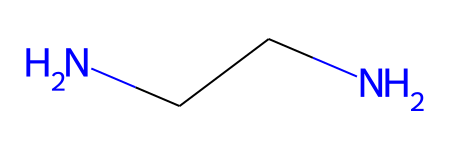

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats
pearson_r: (0.8173201588313516, 0.3909175092762726)
mae: 0.6308106989951435
rmse: 0.9556533280171632
dft_top_5: 1.0
xtb_top_5: 1.0


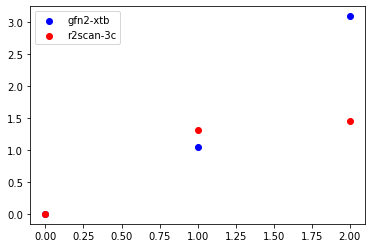

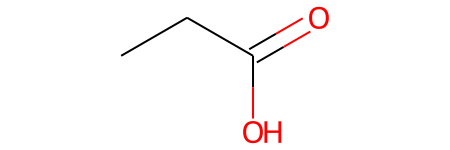

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats
pearson_r: (0.7902688346849855, 0.03443389136976941)
mae: 0.6982629645530584
rmse: 0.7856412644495141
dft_top_5: 0.9999999999999998
xtb_top_5: 0.8755122270922167


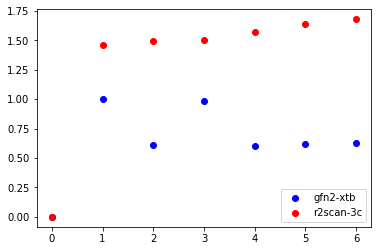

In [5]:
df_tmp = df_subset[df_subset.bin == (0, 0)]
display(df_tmp)
for mol in df_tmp.mol:
    xtb_vs_dft(mol, show_stats=True)

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


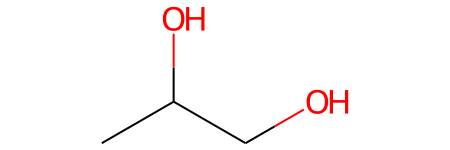

pearson_r: (0.9771110134186777, 0.13647097092609362)
mae: 0.330909287652806
rmse: 0.4097509753008144
dft_top_5: 1.0
xtb_top_5: 1.0


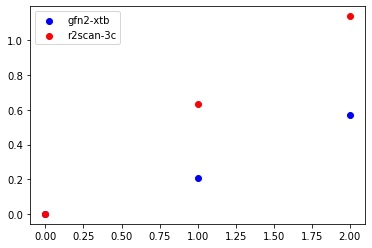

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


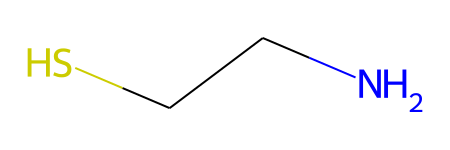

pearson_r: (0.9937725821608682, 0.07108447488277325)
mae: 0.09054517127575916
rmse: 0.11130408499300683
dft_top_5: 1.0
xtb_top_5: 1.0


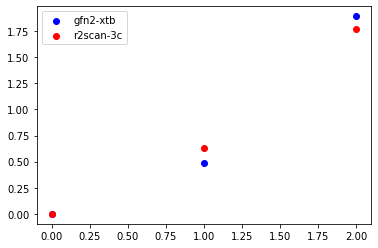

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


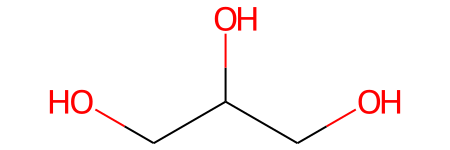

pearson_r: (0.699132586651607, 0.016663089970726738)
mae: 0.4569016845889564
rmse: 0.5656061110364918
dft_top_5: 1.0000000000000002
xtb_top_5: 0.6741555768964256


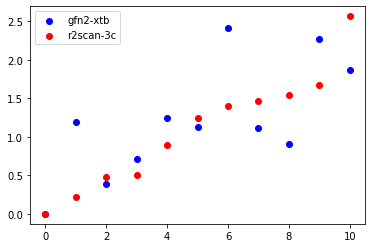

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


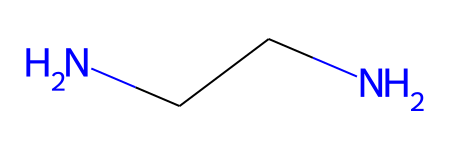

pearson_r: (0.804336154228488, 0.4050423032993314)
mae: 0.6365991963569589
rmse: 0.967495082424614
dft_top_5: 0.9999999999999999
xtb_top_5: 0.9999999999999999


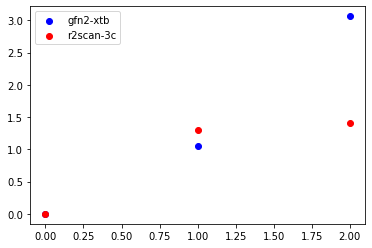

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


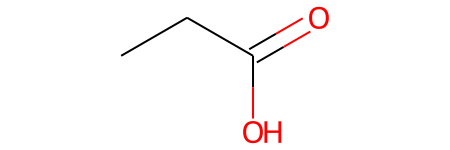

pearson_r: (0.8522287733785524, 0.0311411120910518)
mae: 0.7257232032197862
rmse: 0.8140191693033956
dft_top_5: 0.9999999999999999
xtb_top_5: 0.9393024465941412


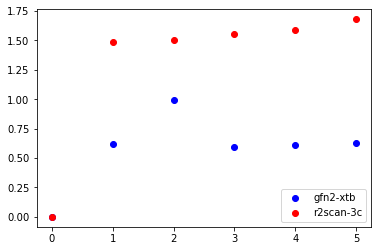

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


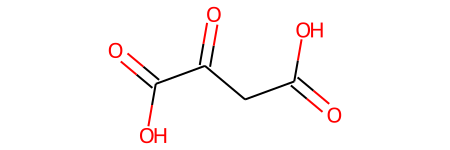

pearson_r: (-0.02767866242222995, 0.9160197217918971)
mae: 1.4393546136227944
rmse: 1.8782416575919547
dft_top_5: 1.0
xtb_top_5: 0.49424712406523197


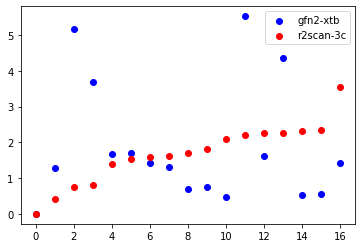

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


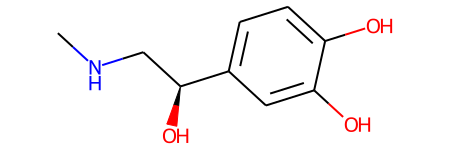

pearson_r: (0.2963759656940249, 0.20450163819182504)
mae: 1.0126633588452023
rmse: 1.1400353177594935
dft_top_5: 0.8285755317905373
xtb_top_5: 0.2588262056779743


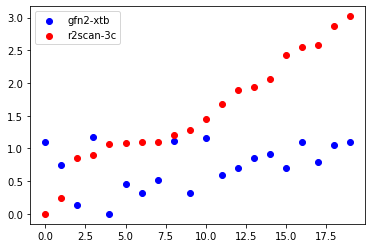

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


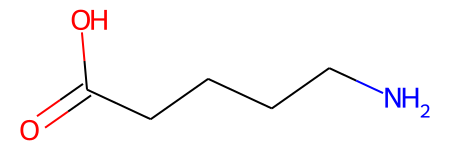

pearson_r: (0.7213472232539573, 0.00033131999778775943)
mae: 1.0618590400887116
rmse: 1.3094839514968775
dft_top_5: 0.9298613249943346
xtb_top_5: 0.8443223286145544


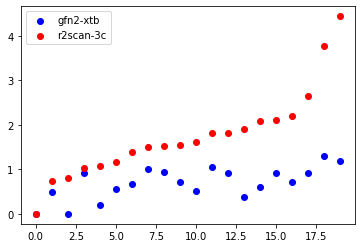

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


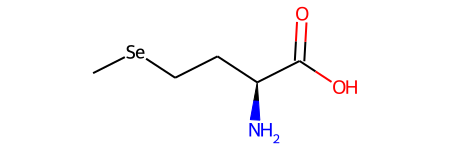

pearson_r: (0.17701815157416645, 0.45530380809604953)
mae: 1.5752366793552937
rmse: 2.080722909166533
dft_top_5: 0.9999999999999999
xtb_top_5: 0.4416968083270323


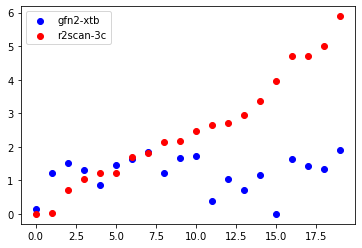

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


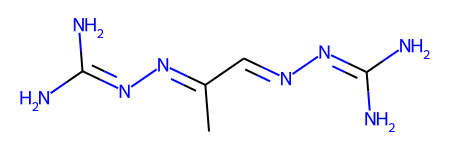

pearson_r: (0.5623011621491629, 0.05703566479322887)
mae: 9.185079450418622
rmse: 10.40335593556371
dft_top_5: 1.0
xtb_top_5: 1.0


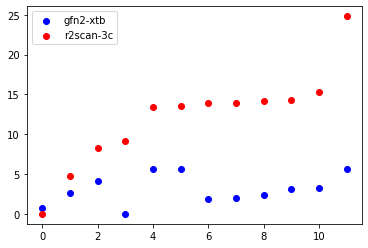

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


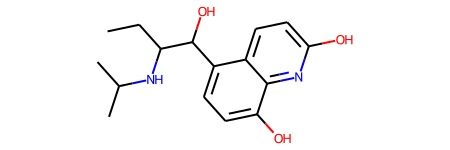

pearson_r: (0.614126874607347, 0.003968682025519347)
mae: 1.3846525376280625
rmse: 1.693305995010509
dft_top_5: 1.0
xtb_top_5: 0.8585302209589175


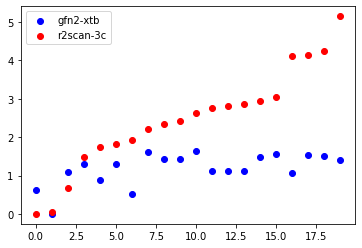

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


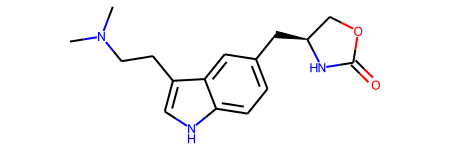

pearson_r: (-0.22263962504784846, 0.3454355861990302)
mae: 1.4351740190948477
rmse: 1.515841479327369
dft_top_5: 0.5705014566057642
xtb_top_5: 0.10978107655521938


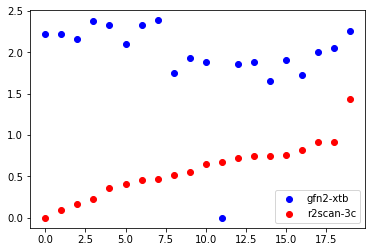

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


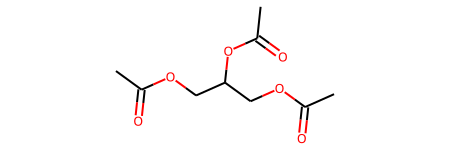

pearson_r: (0.09996877580588355, 0.6749674229284937)
mae: 1.100780233020305
rmse: 1.449494451925904
dft_top_5: 0.8889210464674895
xtb_top_5: 0.6525509828764611


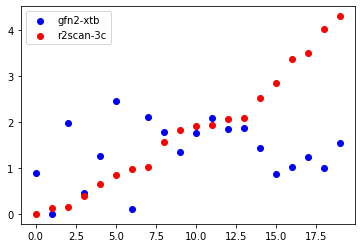

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


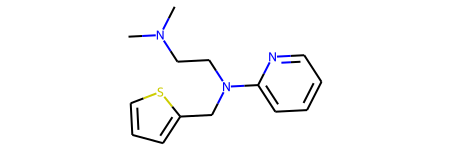

pearson_r: (0.3575341621612197, 0.12170369267561262)
mae: 2.166695534874452
rmse: 2.61391368967288
dft_top_5: 1.0
xtb_top_5: 1.0


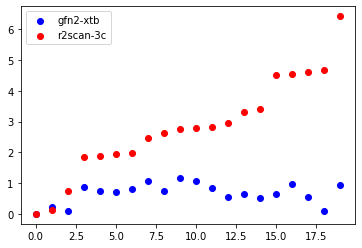

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


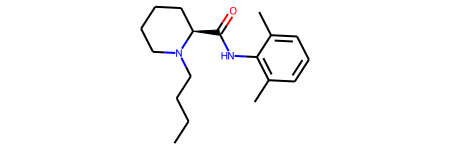

pearson_r: (0.6889218349177931, 0.0007813196004478422)
mae: 1.2563443331768211
rmse: 1.4206530953099052
dft_top_5: 1.0
xtb_top_5: 0.888412770523424


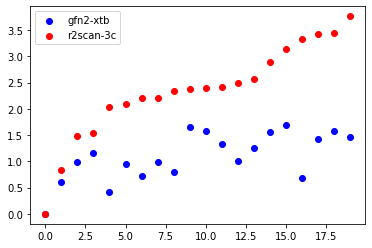

creating initial conformer
finding conformers with crest
getting xtb energies
getting dft energies
collecting stats


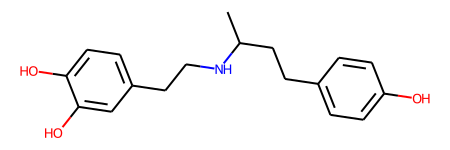

pearson_r: (0.6675957161439259, 0.001298976744990498)
mae: 1.330573524769352
rmse: 1.4745743744005195
dft_top_5: 1.0
xtb_top_5: 1.0


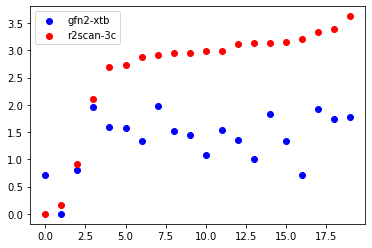

creating initial conformer
finding conformers with crest


crestError: ERROR STOP abnormal termination of crest

Error termination. Backtrace:
#0  0x100d19617
#1  0x100d1a1b7
#2  0x100d1b4ab
#3  0x10079d09f
#4  0x10086902b
#5  0x1008694ef


In [13]:
df_tmp = df_subset[df_subset.bin.isin([
    (0, 0),
    (2, 100),
    (4, 200),
    (6, 300),
    (8, 400),
    (10, 500),
])]
df_tmp['stats'] = df_tmp.mol.apply(lambda x: xtb_vs_dft(x, show_stats=True))

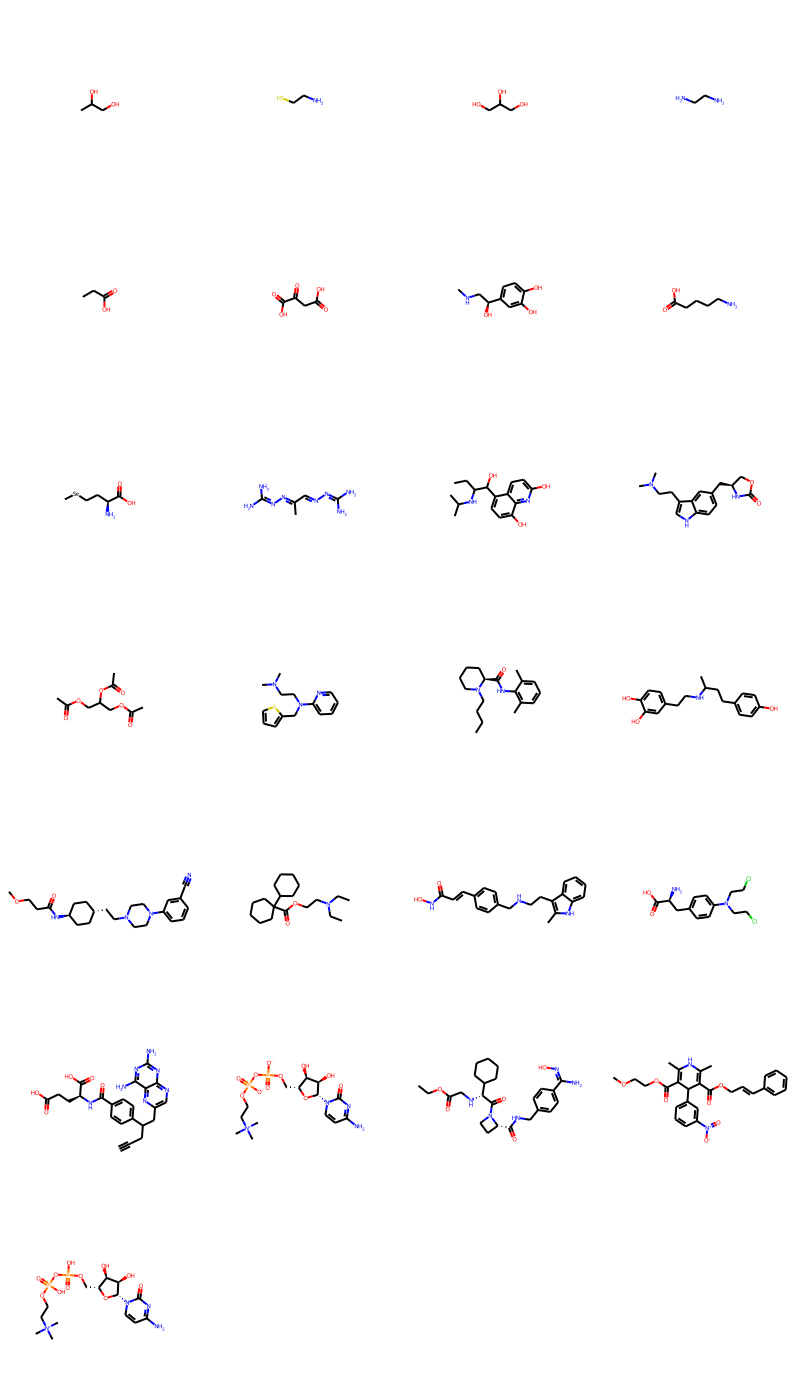

In [16]:
Chem.Draw.MolsToGridImage(
    df_tmp.mol,
    molsPerRow=4
)

In [ ]:
df_tmp.to_pickle('results.pkl')

## prototyping e_xtb vs e_dft

there are 8 conformers
showing the first 4


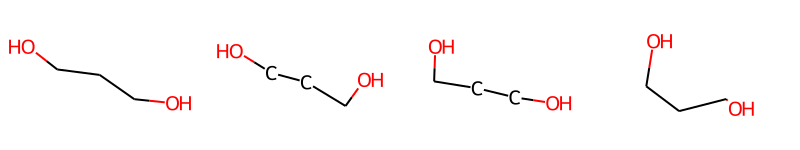

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
mol = Chem.MolFromSmiles('OCCCO')
mols = etkdg.generate_conformers(mol)
print(f'there are {len(mols)} conformers\nshowing the first 4')

conf_utils.align_confs(mols)
display(Chem.Draw.MolsToGridImage(mols=[Chem.RemoveHs(m) for m in mols[:4]], molsPerRow=4, subImgSize=(200,150)))
visualize.mols(mols[:4])

In [17]:
params = crest.Parameters(search_intensity='fast')  # fast takes ~20 s
mols = crest.generate_conformers(mols[0], crest_params=params)
len(mols)

8

In [33]:
df = pd.DataFrame({'mol': mols})

df.head()

,mol
0,<rdkit.Chem.rdchem.Mol object at 0x13afed800>
1,<rdkit.Chem.rdchem.Mol object at 0x148559670>
2,<rdkit.Chem.rdchem.Mol object at 0x13afe4b30>
3,<rdkit.Chem.rdchem.Mol object at 0x13afe4ea0>
4,<rdkit.Chem.rdchem.Mol object at 0x13afe6bb0>


In [36]:
xtb_energies = [gfnxtb.sp(m) for m in df.mol]
min_energy = min(xtb_energies)
xtb_energies = [energy - min_energy for energy in xtb_energies]
df['e_xtb'] = xtb_energies

df.head()

,mol,e_xtb
0,<rdkit.Chem.rdchem.Mol object at 0x13afed800>,0.613869
1,<rdkit.Chem.rdchem.Mol object at 0x148559670>,0.613433
2,<rdkit.Chem.rdchem.Mol object at 0x13afe4b30>,1.579591
3,<rdkit.Chem.rdchem.Mol object at 0x13afe4ea0>,0.000000
4,<rdkit.Chem.rdchem.Mol object at 0x13afe6bb0>,0.197613


In [37]:
dft_energies = [orca_dft.sp(m, orca_dir) for m in df.mol]  # 8 conformers take ~80 s
min_energy = min(dft_energies)
dft_energies = [energy - min_energy for energy in dft_energies]
df['e_dft'] = dft_energies

df.head()

,mol,e_xtb,e_dft
0,<rdkit.Chem.rdchem.Mol object at 0x13afed800>,0.613869,0.284327
1,<rdkit.Chem.rdchem.Mol object at 0x148559670>,0.613433,0.000000
2,<rdkit.Chem.rdchem.Mol object at 0x13afe4b30>,1.579591,0.822637
3,<rdkit.Chem.rdchem.Mol object at 0x13afe4ea0>,0.000000,0.196846
4,<rdkit.Chem.rdchem.Mol object at 0x13afe6bb0>,0.197613,0.313444


In [38]:
df = df.sort_values(['e_dft'])

df.head()

,mol,e_xtb,e_dft
1,<rdkit.Chem.rdchem.Mol object at 0x148559670>,0.613433,0.000000
3,<rdkit.Chem.rdchem.Mol object at 0x13afe4ea0>,0.000000,0.196846
0,<rdkit.Chem.rdchem.Mol object at 0x13afed800>,0.613869,0.284327
4,<rdkit.Chem.rdchem.Mol object at 0x13afe6bb0>,0.197613,0.313444
6,<rdkit.Chem.rdchem.Mol object at 0x13afec5e0>,0.393202,0.523444


In [39]:
boltz = conf_utils.boltzmann_pop(df.e_dft)
boltz += [0] * (len(df) - len(boltz))
df['boltz'] = boltz

df.head()

,mol,e_xtb,e_dft,boltz
1,<rdkit.Chem.rdchem.Mol object at 0x148559670>,0.613433,0.000000,0.278695
3,<rdkit.Chem.rdchem.Mol object at 0x13afe4ea0>,0.000000,0.196846,0.199913
0,<rdkit.Chem.rdchem.Mol object at 0x13afed800>,0.613869,0.284327,0.172471
4,<rdkit.Chem.rdchem.Mol object at 0x13afe6bb0>,0.197613,0.313444,0.164200
6,<rdkit.Chem.rdchem.Mol object at 0x13afec5e0>,0.393202,0.523444,0.115197


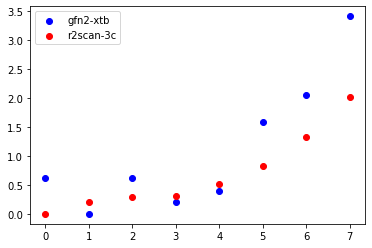

In [40]:
plt.scatter(range(len(df)), df.e_xtb, color='blue', label='gfn2-xtb')
plt.scatter(range(len(df)), df.e_dft, color='red', label='r2scan-3c')
plt.legend()

plt.show()

In [52]:
pearson_r = pearsonr(df.e_xtb, df.e_dft)
mae = mean_absolute_error(df.e_dft, df.e_xtb)
rmse = mean_squared_error(df.e_dft, df.e_xtb, squared=False)
dft_top_5 = sum(df.boltz[:5])
xtb_top_5 = sum(df.sort_values(['e_xtb']).boltz[:5])
print(f'pearson r: {pearson_r}')
print(f'mae: {mae}')
print(f'rmse: {rmse}')
print(f'sum boltzmann pop (dft): {dft_top_5}')
print(f'sum boltzmann pop (xtb): {xtb_top_5}')

pearson r: (0.951579131547992, 0.00027360939148805716)
mae: 0.5342903750386085
rmse: 0.6724525230222342
sum boltzmann pop (dft): 0.930476373071384
sum boltzmann pop (xtb): 0.9304763730713839


## meep